# Parameter estimation example

In this notebook we show how to do some simple parameter estimation on the binary neutron star coalescense signal GW170817. This uses data from the [LIGO Open Science Center (LOSC)](https://losc.ligo.org). Here we will compute the posterior probability distribution over the distance to the source and the coalescense time, whilst holding all other values fixed at assumed known values.

The `readligo` module used below to read in a HDF5 file containing LIGO strain data can be extracted from the LOSC tutorial [here](https://losc.ligo.org/s/events/LOSC_Event_tutorial.zip). The data for GW170817 that we use is the cleaned data sampled at 4096 Hz in HDF5 format ([H1 data](https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5), [L1 data](https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5)). We only use data from one detector below, but both could be combined by defining a joint likelihood function.

In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
import numpy as np

import readligo as rl

First, we define a function that generates and returns the $+$ and $\times$-polarisation components of a frequency domain binary coalescense signal. This makes use of the [`XLALSimInspiralChooseFDWaveform()`](https://docs.ligo.org/lscsoft/lalsuite/lalsimulation/group___l_a_l_sim_inspiral__c.html#ga50d4b23c4b6a80e93d4ed5ea7d90113b) function from the [LALSimulation](https://docs.ligo.org/lscsoft/lalsuite/lalsimulation/index.html) library. Below, it is hardcoded to use the IMRPhenomPv2 waveform family, but [other waveform families](https://lscsoft.docs.ligo.org//lalsuite/lalsimulation/group___l_a_l_sim_inspiral__h.html#gab955e4603c588fe19b39e47870a7b69c) can be used instead.

In [2]:
import lal
import lalsimulation

def fdwaveform(phiref, deltaF, m1, m2, fmin, dist, incl, spin1x=0., spin1y=0., spin1z=0.,
               spin2x=0., spin2y=0, spin2z=0., fmax=0, fref=None):
    """
    A function to generate a frequency domain inspiral waveform. This function sets spin
    parameters to zero, so all output are non-spinning waveforms. The reference frequency is set to fmin.
    
    This function does not include the antenna patterns, so is detector and sky position
    independent.

    Args:
        phiref (float): the reference phase (rads)
        deltaF (float): the frequency bin size (Hz)
        m1 (float): the mass of the first component (solar masses)
        m2 (float): the mass of the second component (solar masses)
        fmin (float): the lower bound on frequency (Hz)
        dist (float): the source distance (in Mpc)
        incl (float): the source inclination angle (rads)
        spin1x,y,z (float): the spin components of the first binary component
        spin2x,y,z (float): the spin components of the second binary component
        fmax (float): maximum frequency for signal (Hz) (default of 0 computes signal up to ISCO for TaylorF2)
        fref (float): the reference frequency (Hz) (defaults to fmin)

    Returns:
        the plus and cross polarisation components of the signal in the frequency domain.
    """  

    approx = lalsimulation.IMRPhenomPv2
    #approx = lalsimulation.TaylorF2 # Taylor F2 approximant (you can change this to e.g. lalsimulation.IMRPhenomPv2)
    if fref is None:
        fref = fmin
 
    hptilde, hctilde = lalsimulation.SimInspiralChooseFDWaveform(
        m1*lal.MSUN_SI, m2*lal.MSUN_SI, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z, dist*1e6*lal.PC_SI, incl,
        phiref, 0., 0., 0., deltaF, fmin, fmax, fref, None, approx)

    # return the frequency domain plus and cross waveforms
    return hptilde.data.data, hctilde.data.data

The function below computes the antenna reposonse (also known as antenna pattern, or beam function) for particular source location and polarisation angle impinging on a given detector at a given time (in GPS seconds). The function below can take in detector values of `'H1'`, `'L1'`, or `'V1'`, for the LIGO Hanford, LIGO Livingston, and Virgo detectors, respectively.

In [3]:
def antenna_response( gpsTime, ra, dec, psi, det ):
    """
    Get the response of a detector to plus and cross polarisation signals.

    Args:
        gpsTime (float): the GPS time of the observations
        ra (float): the right ascension of the source (rads)
        dec (float): the declination of the source (rads)
        psi (float): the polarisation angle of the source (rads)
        det (str): a detector name (e.g., 'H1' for the LIGO Hanford detector)
    
    Returns:
        The plus and cross response.
    """

    gps = lal.LIGOTimeGPS( gpsTime )
    gmst_rad = lal.GreenwichMeanSiderealTime(gps)

    # create detector-name map
    detMap = {'H1': lal.LALDetectorIndexLHODIFF,
              'L1': lal.LALDetectorIndexLLODIFF,
              'V1': lal.LALDetectorIndexVIRGODIFF,}

    try:
        detector=detMap[det]
    except KeyError:
        raise ValueError("ERROR. Key {} is not a valid detector name.".format(det))

    # get detector
    detval = lal.CachedDetectors[detector]

    response = detval.response

    # actual computation of antenna factors
    fp, fc = lal.ComputeDetAMResponse(response, ra, dec, psi, gmst_rad)

    return fp, fc

The function below defines the natural logarithm of the [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function) that is commonly used in gravitational wave parameter estimation. The likelihood function is a [Gaussian likelihood](https://en.wikipedia.org/wiki/Normal_distribution), but taking in a complex frequency series for the data and model, and noise defined through the one-sided [power spectral density](https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density) of the data. A definition of this function can be found in, e.g., Equation 10 of [Veitch _et al_, PRD, **91**, 042003 (2015)](https://arxiv.org/abs/1409.7215), where we ignore the second line in their definition.

In [4]:
def loglikelihood(data, model, psd, deltaF):
    """
    The log likelihood function.
    
    Args:
        data (array): the complex frequency domain data
        model (array): the complex frequency domain model
        psd (array): the power spectral density estimate
        deltaF (float): the frequency step size
    """

    # get the difference between the data and the model
    diff = data - model
    
    # whiten this (divide by the ASD (sqrt of the PSD))
    diff /= np.sqrt(psd)

    # make sure any infinite values are zero'd (e.g. caused by ASD values that are zero)
    diff[~np.isfinite(diff)] = 0.

    # get the cross product (d-m)(d-m)
    chisq = np.vdot(diff, diff).real # the value will be real by definition, but we explicitly take the real part to discard the 0-values imaginary component
    
    chisq *= 2.*deltaF

    # the log likelihood function
    L = -chisq
    
    return L

Below, we read in data for the LIGO Livingston detector, which has been downloaded to a known location. Alternatively, we could download the files to our current directory using the Python [requests](http://docs.python-requests.org/en/master/) module, with e.g.:

```python
import requests

# set dictionary of HDF5 file names
filenames = {'H1': 'H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5',
             'L1': 'L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'}

# set the data URL
baseurl = 'https://dcc.ligo.org/public/0146/P1700349/001/'

det = 'L1'

r = requests.get(baseurl + filenames[det])
fp = open(filenames[det], 'wb')
fp.write(r.content)
fp.close()
```

The cell below also contains the trigger time for the signal (i.e., the time returned by the detection algorithm that detected the signal). In particular, this is the trigger time returned by the gstlal search pipeline for event [G298048](https://gracedb.ligo.org/events/view/G298048).

In [5]:
%%capture

# read in L1 data for GW170817
hdffiles = {'H1': '/local/scratch/LIGO/GW170817/H-H1_LOSC_CLN_4_V1-1187007040-2048.hdf5',
            'L1': '/local/scratch/LIGO/GW170817/L-L1_LOSC_CLN_4_V1-1187007040-2048.hdf5'}

det = 'L1'

strain, times, channeldic = rl.loaddata(hdffiles[det], tvec=True) # return timestamp vector with tvec=True

srate = 1./(times[1]-times[0])         # set the sample rate
trigtime = 1187008882.4457             # trigger time
pidx = int((trigtime-times[0])*srate)  # index of signal trigger in the data time series

Below, we set the duration of the data used for the parameter inference, and for the segment size for the power spectrum estimation. We use the slightly odd duration of 106.66666 seconds, as this was used for the analysis that produced results for the [Hubble constant](https://arxiv.org/abs/1710.05835) estimation paper. For the analsis segment we use up until 2 seconds past the end of the trigger time. 

In [6]:
# get 106.666 seconds of data up to 2 seconds after the peak
dur = 106. + (2./3.)
pads = 2

sigdata = strain[pidx-int((dur-pads)*srate):pidx+int(pads*srate)] # data containing the signal
t0 = times[pidx-int((dur-pads)*srate)]                            # start time of that data

To estimate the power spectral density we will use the functions within LAL. In particular we will use the [`XLALREAL8AverageSpectrumMedian()`](https://docs.ligo.org/lscsoft/lalsuite/lal/group___time_freq_f_f_t__h.html#ga6401e383dfa49360cbd54b818589b3c6) function, which computes a spectrum from the median of a set of segments. This is used as it is the default for the [LALInference](https://arxiv.org/abs/1409.7215) parameter estimation codes, although the Welch method could also be used (but may be more biased by any load signals or glitches in the data used for the estimation). For the power spectrum each segment is [Tukey windowed](https://en.wikipedia.org/wiki/Window_function#Tukey_window), with a window created using the [`XLALCreateTukeyREAL8Window()`](https://docs.ligo.org/lscsoft/lalsuite/lal/group___window__h.html) function (the Tukey window from the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.tukey.html) module could be used instead). 

In [7]:
# get running median PSD
time = lal.LIGOTimeGPS(int(times[0]), 0) # set a GPS epoch for the time series (this can just be a "dummy" value)

length = len(strain)    # the number of samples in the time series data
nfft = int(dur*srate)   # number of time samples to use per FFT
stride = int(dur*srate) # the "stride" for the next FFT (dictates how many FFTs are averaged and overlap) 
nsegs = int(length/nfft)

deltaF = srate/nfft     # frequency step size
nbin = int((nfft/2)+1)  # number of frequency bins
deltaT = 1./srate # time step size

# put data into a time series object
data = lal.CreateREAL8TimeSeries("time data", time, 0.0, deltaT, lal.DimensionlessUnit, nsegs*nfft)
for i in range(nsegs*nfft):
    data.data.data[i] = strain[i] # put the data into the REAL8TimeSeries

# set the Tukey window
alpha = 2*srate*0.4/nfft
window = lal.CreateTukeyREAL8Window(nfft, alpha)

# create an "FFT plan"
FFTPlan = lal.CreateForwardREAL8FFTPlan(nfft, 1)

# create a frequency series object to hold the PSD
psdlalmedian = lal.CreateREAL8FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)

# create the PSD using the median method
lal.REAL8AverageSpectrumMedian(psdlalmedian, data, nfft, stride, window, FFTPlan);

Below we set up source parameters for generating signal templates to compare against the data when producing our posterior probability distributions. We assume a fixed sky position, that for the galaxy NGC4993. The other values are set from the maximum _a posteriori_ parameter estimates from a fixed sky position [run](https://ldas-jobs.ligo.caltech.edu/~katerina.chatziioannou/O2/PE/G298048/ProductionRuns/Prod2/lalinferencenest/IMRPhenomPv2pseudoFourPN/128s/1187008882.45-0/V1H1L1/posplots.html) using the IMRPhenomPv2 waveform, as used for the [Hubble constant](https://arxiv.org/abs/1710.05835) estimation paper.

In [9]:
# create a signal model
ra = 3.446157844    # use fixed position of NGC4993
dec = -0.4080841591

# component masses
m1 = 1.72140419742
m2 = 1.10859297829

# this is used as the fiducial distance for waveform templates
distance = 44.6889906553

phiref = 2.60174675393   # reference phase
psi = 0.860990548555     # polarisation angle
timec = 1187008882.3802  # coalescense time

# spin and orientation parameters
thetaJN = 2.74719229269
aspin1 = 0.264813928565
aspin2 = 0.702414508316
phi12 = 4.81306908412
tilt1 = 2.58869030589
tilt2 = 0.948965945788
phiJL = 6.04852924541

fmin = 24    # use frequencies above 24 Hz
fref = 100   # reference frequency for spin/precession parameters
fmax = 400   # use frequencies up to 400 Hz (this is an arbitrary choice)

# get time delay from Earth center to a given detector to apply to template
# create detector-name map
detMap = {'H1': lal.LALDetectorIndexLHODIFF,
          'L1': lal.LALDetectorIndexLLODIFF,
          'V1': lal.LALDetectorIndexVIRGODIFF,}

detector=detMap[det]
detval = lal.CachedDetectors[detector]
etime = lal.LIGOTimeGPS(int(timec), int(1e9*(timec-np.floor(timec))))
tdelay = lal.TimeDelayFromEarthCenter(detval.location, ra, dec, etime)

# indexes of min and max frequency ranges
minidx = int(np.ceil(fmin/deltaF))
maxidx = int(np.floor(fmax/deltaF))+1 # add 1 so the slice gets all the required values

freqs = np.fft.rfftfreq(nfft, d=1./srate) # get the frequencies of the data/model

# get a range of coalesence times to calculate the model at
timeshifts = np.linspace(timec-1e-3, timec+1e-3, 200)

# calculate signals model at a range of phis for a fixed distance
sigmodels = []

# get equivalent spin parameters for IMRPhenomPv2 signal model
iota, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = lalsimulation.SimInspiralTransformPrecessingNewInitialConditions(
                                                                     thetaJN, phiJL, tilt1,
                                                                     tilt2, phi12, aspin1, aspin2,
                                                                     m1*lal.MSUN_SI, m2*lal.MSUN_SI, fref, phiref)

# calculate the signal model at the fiducial values
hplus, hcross = fdwaveform(phiref, deltaF, m1, m2, fmin, distance, iota, spin1x=spin1x, spin1y=spin1y,
                               spin1z=spin1z, spin2x=spin2x, spin2y=spin2y, spin2z=spin2z, fmax=fmax, fref=fref)

# compute the antenna response
Fp, Fx = antenna_response( timec, ra, dec, psi, det )

# only get values in the required frequency range
template = hplus[minidx:maxidx]*Fp + hcross[minidx:maxidx]*Fx

# calculate the phase shifts required
for i, t in enumerate(timeshifts):
    dt = (t - t0) + tdelay
    twopit = 2.*np.pi*dt
    shifts = np.exp(-1j*twopit*freqs[minidx:maxidx])

    # apply time shifts
    sigmodels.append(template*shifts)

Below we window and FFT the data that contains the signal and will be used for the parameter estimation. We use the LAL FFT functions, although the `numpy.fft.rfft` function could be used, with the caveat that it must be divided by the sample rate to have the same required definition as the equivalent LAL function, e.g.

```python
# using numpy FFT function
fdata = np.fft.rfft(window.data.data*sigdata)/srate
```

In [10]:
# window and FFT the data
# create the frequency series that will contain the FFT
lalfft = lal.CreateCOMPLEX16FrequencySeries("spectrum", time, 0.0, deltaF, lal.DimensionlessUnit, nbin)

# create a time series to hold the windowed data
windata = lal.CreateREAL8TimeSeries("time data", time, 0.0, deltaT, lal.DimensionlessUnit, len(sigdata))

# window the data
for i in range(len(sigdata)):
    windata.data.data[i] = window.data.data[i]*sigdata[i] # put the data into the REAL8TimeSeries

# perform the FFT
lal.REAL8TimeFreqFFT(lalfft, windata, FFTPlan);

Below we just extract the parts to the FFTed data and PSD over the range of frequencies that we require. We also perform a minor scaling of the FFTed data to account for the small loss in power due to the edges of the window.

In [11]:
# make signal, model and PSD the same length
freqsc = freqs[minidx:maxidx]

# include minor correction to account for loss of power from windowing
fdatac = lalfft.data.data[minidx:maxidx]/np.sqrt(window.sumofsquares/window.data.length)

psdc = psdlalmedian.data.data[minidx:maxidx]

Now we can calculate the (natural logarithm of the) posterior probability distribution over distance and coalescense times. As the distance just scales the waveform amplitude we can just apply the appropriate scaling to each waveform model, rather than having to recalculate the waveform. We also apply a prior on the distance that is equivalent to having a uniform in volume prior, e.g.: if

$$
p(V|I) = C,
$$

where $C$ is a constant, and

$$
V = \frac{4}{3} \pi r^3,
$$

where $r$ is distance, then

$$
\frac{{\rm d}V}{{\rm d}r} = 4 \pi r^2,
$$

and

$$
p(r|I) = p(V|I) \left| \frac{{\rm d}V}{{\rm d}r} \right| \propto r^2
$$

and therefore

$$
\ln{p(r|I)} = {\rm const.} + 2\ln{r}.
$$

In [12]:
dists = np.linspace(10., 100., 100)

# calculate log likelihood over coalescense time and distance

logL = np.zeros((len(timeshifts), len(dists)))
for i in range(len(timeshifts)):
    for j, dist in enumerate(dists):
        tmodel = sigmodels[i] * distance / dist

        L = loglikelihood(fdatac, tmodel, psdc, deltaF)

        prior = 2.*np.log(dist) # compute uniform in volume prior

        logL[i, j] = L + prior # include prior

Below we plot the joint 2D posterior and then the individual posteriors marginalised over the other parameter. Note that we subtract the maximum of the the log posterior values to avoid numerical overflow issues.

**It is very important to note that here we have assumed a fixed value of the inclination of the system through the $\cos{\theta_{JN}}$ parameter. This value is highly correlated with the distance and as such they should really both be jointly estimated, and $\cos{\theta_{JN}}$ marginalised over. Because of this, the distance estimated here purely from the gravitational wave data appears inconsistent with the distance to NCG 4993, and will look narrower than the posterior provided in the [Hubble constant estimation paper]((https://arxiv.org/abs/1710.05835).**

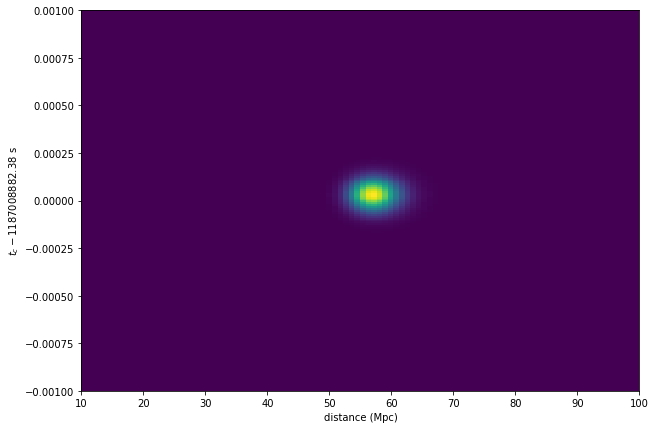

In [19]:
# show posterior
fig, ax = pl.subplots(figsize=(10,7))

ax.imshow(np.flipud(np.exp(logL-np.max(logL.flatten()))), aspect='auto', extent=(dists[0], dists[-1], timeshifts[0]-timec, timeshifts[-1]-timec))
ax.set_xlabel(r'distance (Mpc)');
ax.set_ylabel(r'$t_c - {0:.2f}$ s'.format(timec));

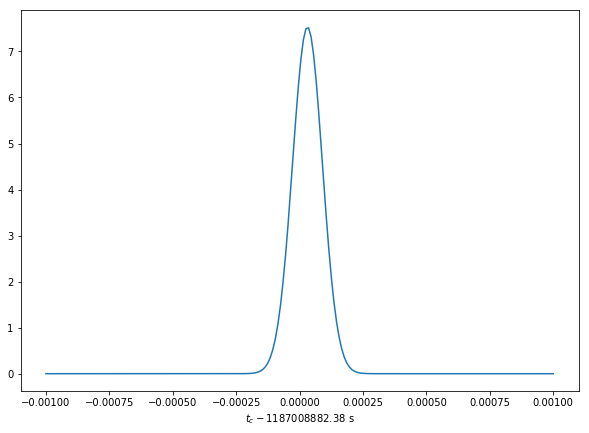

In [14]:
# plot the coalesence time posterior
post = np.exp(logL-np.max(logL.flatten()))
posttime = np.array([np.sum(p) for p in post])

fig, ax = pl.subplots(figsize=(10,7))
ax.plot(timeshifts-timec, posttime)
ax.set_xlabel(r'$t_c - {0:.2f}$ s'.format(timec));

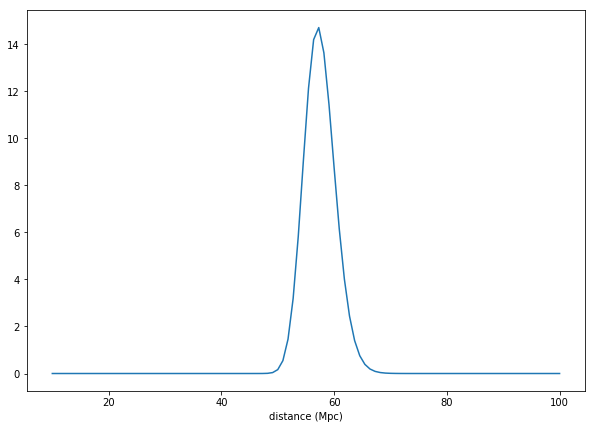

In [15]:
# plot distance posterior
postdist = np.array([np.sum(p) for p in post.T])

fig, ax = pl.subplots(figsize=(10,7))
ax.plot(dists, postdist)
ax.set_xlabel(r'distance (Mpc)');